## Importy

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
from fuzzython.fsets.triangular import Triangular
# klasa Variable - zmienna lingwistyczna
from fuzzython.variable import Variable
# klasa Adjective - wartość zmiennej lingwistycznej
from fuzzython.adjective import Adjective

from fuzzython.ruleblock import RuleBlock
from fuzzython.systems.mamdani import MamdaniSystem
from fuzzython.systems.sugeno import SugenoSystem
from fuzzython.fsets.gaussian import Gaussian
from fuzzython.fsets.zfunction import ZFunction
from fuzzython.fsets.sfunction import SFunction

In [33]:
# funkcja pomocnicza rysująca zbiory rozmyte
def plot_fuzzyset(ax, fuzzy_set, x, *args, **kwargs):
    y = np.array([fuzzy_set(e) for e in x])
    ax.plot(x, y,  *args, **kwargs)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

## Zadanie 1

In [34]:
# zmienna lingwistyczna `velocity` opisująca prędkość samochodu w zakresie od 10 do 200 km/h
# cztery wartości lingwistyczne, zbiory rozmyte: `ve_low`, `ve_medium`, `ve_high`, `ve_very_high`

ve_low = Triangular((9.9,0), (10,1), (73,0))
ve_medium = Triangular((10,0), (73,1), (137,0))
ve_high = Triangular((73,0), (137,1), (200,0))
ve_very_high = Triangular((137,0), (200, 1), (200.1, 0))

a_ve_low = Adjective('ve_low', ve_low)
a_ve_medium = Adjective('ve_medium', ve_medium)
a_ve_high = Adjective('ve_high', ve_high)
a_ve_very_high = Adjective('ve_very_high', ve_very_high)
velocity = Variable('velocity', 'km/h', a_ve_low, a_ve_medium, a_ve_high, a_ve_very_high)

# zmienna lingwistyczna `visibility` widzialność w skali od 0.05 do 4 km
# trzy wartości lingwistyczne, zbiory rozmyte: `vi_poor`, `vi_average`, `vi_good`

vi_poor = Triangular((0, 0), (0.04, 1), (2,0))
vi_average = Triangular((0.04, 0), (2,1), (4,0))
vi_good = Triangular((2,0), (4,1), (4.01, 0))

a_vi_poor = Adjective('vi_poor', vi_poor)
a_vi_average = Adjective('vi_average', vi_average)
a_vi_good = Adjective('vi_good', vi_good)
visibility = Variable('visibility', 'km', a_vi_poor, a_vi_average, a_vi_good)

# zmienna lingwistyczna `accident` opisująca wysokość przekonania o możliwości spowodowania wypadku w skali od 0 do 1
# cztery wartości lingwistyczne, zbiory rozmyte: `ac_very_low`, `ac_low`, `ac_medium`, `ac_high`

ac_very_low = Triangular((-0.1, 0), (0, 1), (0.33, 0))
ac_low = Triangular((0,0), (0.33, 1), (0.66, 0))
ac_medium = Triangular((0.33, 0), (0.66, 1), (1, 0))
ac_high = Triangular((0.66, 0), (1,1), (1.1, 0))

a_ac_very_low = Adjective('ac_very_low', ac_very_low)
a_ac_low = Adjective('ac_low', ac_low)
a_ac_medium = Adjective('ac_medium', ac_medium)
a_ac_high = Adjective('ac_high', ac_high)
accident = Variable('accident', '', a_ac_very_low, a_ac_low, a_ac_medium, a_ac_high, defuzzification='COG', default=0)

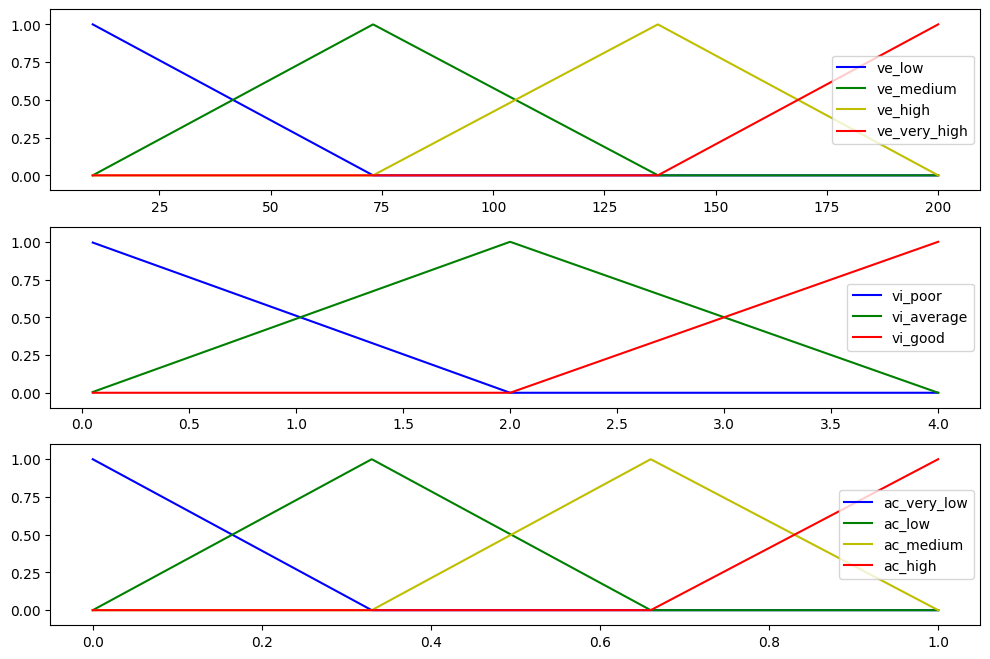

In [35]:
# wykresy poglądowe
x = np.linspace(10,200,1000)
x2 = np.linspace(0.05,4,1000)
x3 = np.linspace(0,1,1000)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
((ax1), (ax2), (ax3)) = axs

plot_fuzzyset(ax1, ve_low, x, 'b', label='ve_low')
plot_fuzzyset(ax1, ve_medium, x, 'g', label='ve_medium')
plot_fuzzyset(ax1, ve_high, x, 'y', label='ve_high')
plot_fuzzyset(ax1, ve_very_high, x, 'r', label='ve_very_high')
plot_fuzzyset(ax2, vi_poor, x2, 'b', label='vi_poor')
plot_fuzzyset(ax2, vi_average, x2, 'g', label='vi_average')
plot_fuzzyset(ax2, vi_good, x2, 'r', label='vi_good')
plot_fuzzyset(ax3, ac_very_low, x3, 'b', label='ac_very_low')
plot_fuzzyset(ax3, ac_low, x3, 'g', label='ac_low')
plot_fuzzyset(ax3, ac_medium, x3, 'y', label='ac_medium')
plot_fuzzyset(ax3, ac_high, x3, 'r', label='ac_high')
plt.show()

In [36]:
scope = locals()

rule1 = 'if velocity is a_ve_very_high then accident is a_ac_high'
rule2 = 'if velocity is a_ve_high then accident is a_ac_medium'
rule3 = 'if velocity is a_ve_medium then accident is a_ac_low'
rule4 = 'if velocity is a_ve_low then accident is a_ac_very_low'
rule5 = 'if visibility is a_vi_good then accident is a_ac_very_low'
rule6 = 'if visibility is a_vi_average then accident is a_ac_medium'
rule7 = 'if visibility is a_vi_poor then accident is a_ac_high'
rule8 = 'if velocity is a_ve_medium and visibility is a_vi_average then accident is a_ac_medium'
rule9 = 'if velocity is a_ve_very_high and visibility is a_vi_poor then accident is a_ac_high'

block = RuleBlock('rb_mamdani', operators=('MIN','MAX','ZADEH'), activation='MIN', accumulation='MAX')
block.add_rules(rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, scope=scope)

mamdani = MamdaniSystem('mamdani_model', block)

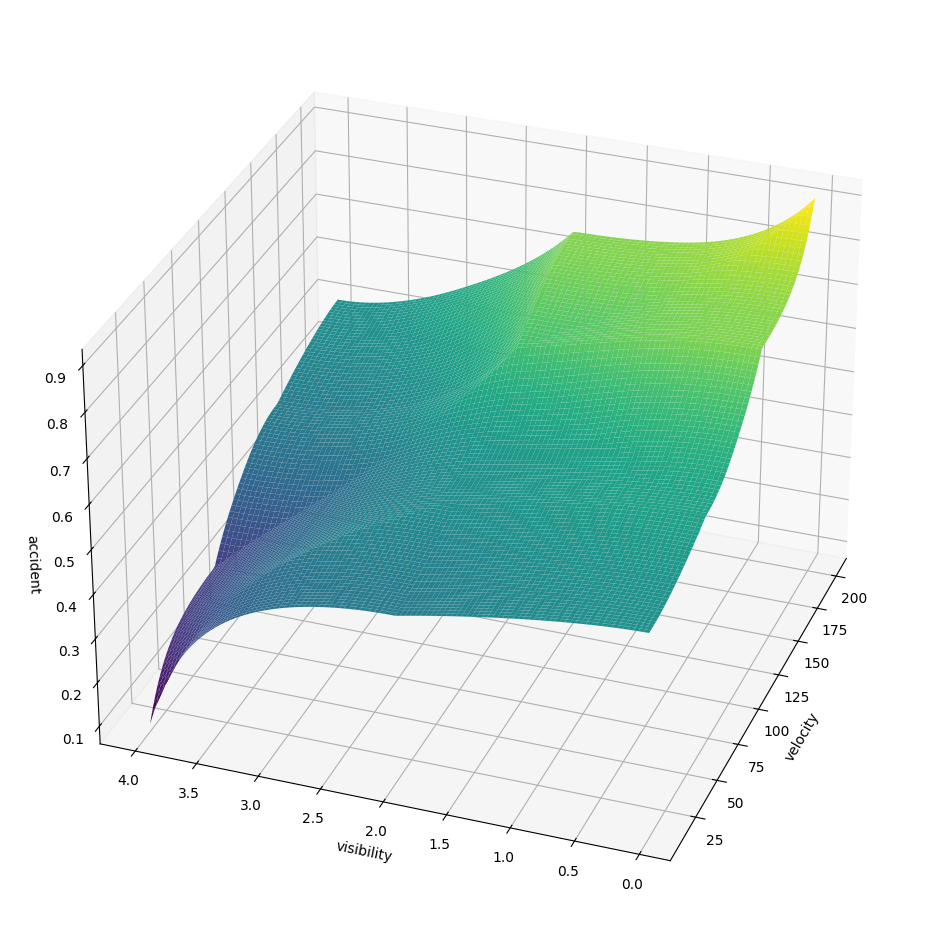

In [37]:
sampled1 = np.linspace(10, 200, 100)
sampled2 = np.linspace(0.05, 4, 100)
x, y = np.meshgrid(sampled1, sampled2)
z = np.zeros((len(sampled1),len(sampled2)))

for i in range(len(sampled1)):
    for j in range(len(sampled2)):
        inputs = {'velocity': x[i, j], 'visibility': y[i, j]}
        res = mamdani.compute(inputs)
        z[i, j] = res['rb_mamdani']['accident']

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)
ax.set_xlabel('velocity')
ax.set_ylabel('visibility')
ax.set_zlabel('accident')
ax.view_init(30, 200)

## Zadanie 2

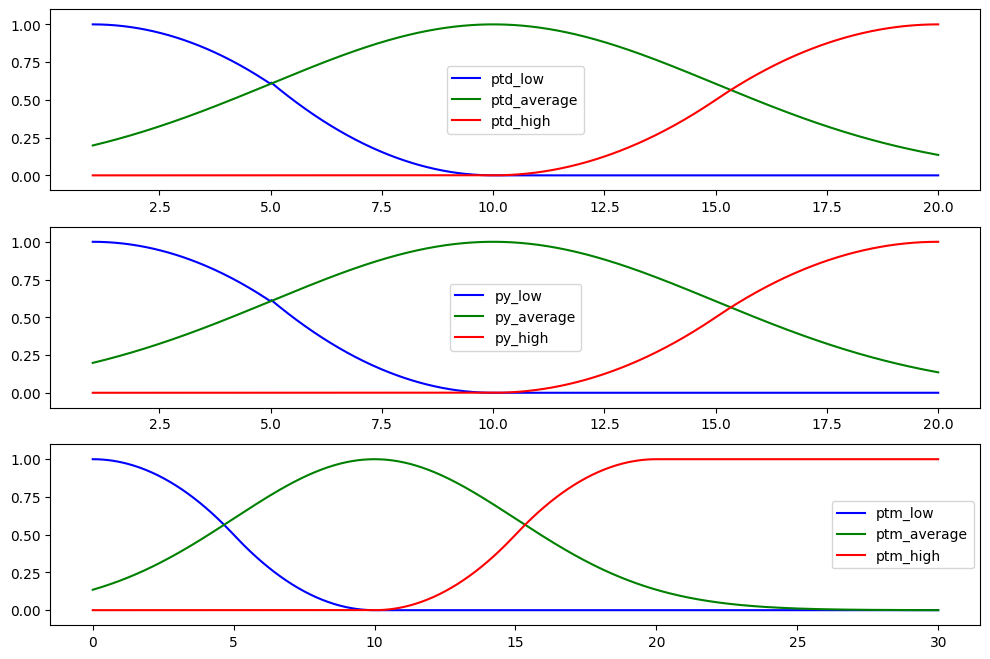

In [41]:
# zmienna lingwistyczna `price_today` opisująca cenę akcji dzisiaj w skali od 1 do 20 złotych (zł)
# trzy wartości lingwistyczne, zbiory rozmyte: `pt_low`, `pt_average`, `pt_high`

ptd_low = ZFunction((1,0), 5, (10,1))
ptd_average = Gaussian(10, 5)
ptd_high = SFunction((10,0), 15, (20,1))
a_ptd_low = Adjective('ptd_low', ptd_low)
a_ptd_average = Adjective('ptd_average', ptd_average)
a_ptd_high = Adjective('ptd_high', ptd_high)
price_today = Variable('price_today', 'zl', a_ptd_low, a_ptd_average, a_ptd_high)

# zmienna lingwistyczna `price_yesterday` opisująca cenę akcji wczoraj w skali od 1 do 20 złotych (zł)
# trzy wartości lingwistyczne, zbiory rozmyte: `py_low`, `py_average`, `py_high`

py_low = ZFunction((1,0), 5, (10,1))
py_average = Gaussian(10, 5)
py_high = SFunction((10,0), 15, (20,1))
a_py_low = Adjective('py_low', py_low)
a_py_average = Adjective('py_average', py_average)
a_py_high = Adjective('py_high', py_high)
price_yesterday = Variable('price_yesterday', 'zl', a_py_low, a_py_average, a_py_high)

# zmienna lingwistyczna `price_tomorrow` opisująca cenę akcji jutro (zł)
# trzy wartości lingwistyczne, zbiory rozmyte: `pt_low`, `pt_average`, `pt_high`

ptm_low = ZFunction((0,0), 5, (10,1))
ptm_average = Gaussian(10, 5)
ptm_high = SFunction((10,0), 15, (20,1))
a_ptm_low = Adjective('ptm_low', ptm_low)
a_ptm_average = Adjective('ptm_average', ptm_average)
a_ptm_high = Adjective('ptm_high', ptm_high)
price_tomorrow = Variable('price_tomorrow', 'zl', a_ptm_low, a_ptm_average, a_ptm_high, defuzzification='COG', default=0)

# wykresy poglądowe
x = np.linspace(1,20,1000)
x2 = np.linspace(0,30,1000)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
((ax1), (ax2), (ax3)) = axs
plot_fuzzyset(ax1, ptd_low, x, 'b', label='ptd_low')
plot_fuzzyset(ax1, ptd_average, x, 'g', label='ptd_average')
plot_fuzzyset(ax1, ptd_high, x, 'r', label='ptd_high')
plot_fuzzyset(ax2, py_low, x, 'b', label='py_low')
plot_fuzzyset(ax2, py_average, x, 'g', label='py_average')
plot_fuzzyset(ax2, py_high, x, 'r', label='py_high')
plot_fuzzyset(ax3, ptm_low, x2, 'b', label='ptm_low')
plot_fuzzyset(ax3, ptm_average, x2, 'g', label='ptm_average')
plot_fuzzyset(ax3, ptm_high, x2, 'r', label='ptm_high')
plt.show()

In [44]:
scope = locals()

rule10 = 'if price_today is a_ptd_low or price_yesterday is a_py_low then z=price_today*0.9+price_yesterday*0.85+12'
rule11 = 'if price_today is a_ptd_average then z=price_today*0.9+12'
rule12 = 'if price_today is a_ptd_high or price_yesterday is a_py_high then z=price_today*0.3+price_yesterday*0.5-10'

block = RuleBlock('rb_takagi', operators=('MIN', 'MAX', 'ZADEH'), activation='MIN', accumulation='MAX')
block.add_rules(rule10, rule11, rule12, scope=scope)

sugeno = SugenoSystem('model_takagi', block)

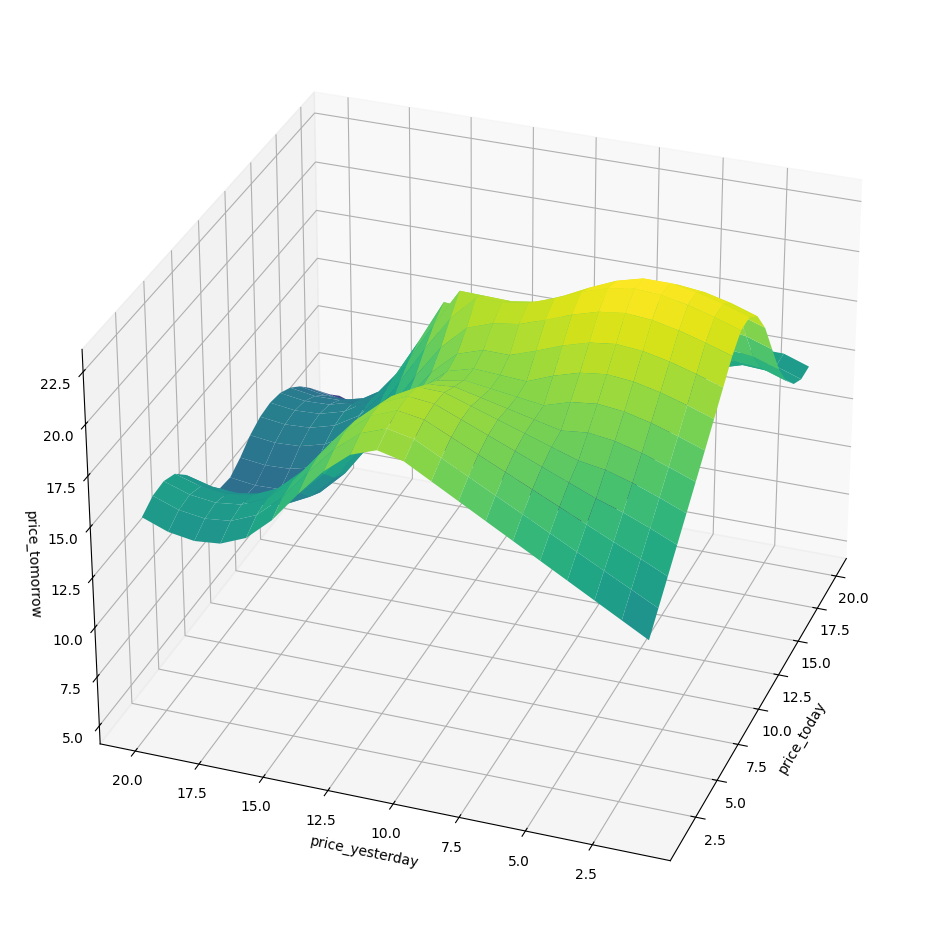

In [46]:
sampled = np.linspace(1, 20, 20)
x, y = np.meshgrid(sampled, sampled)
z = np.zeros((len(sampled),len(sampled)))

for i in range(len(sampled)):
    for j in range(len(sampled)):
        inputs = {'price_today': x[i, j], 'price_yesterday': y[i, j]}
        res = sugeno.compute(inputs)
        z[i, j] = res['rb_takagi']

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)
ax.set_xlabel('price_today')
ax.set_ylabel('price_yesterday')
ax.set_zlabel('price_tomorrow')
ax.view_init(30, 200)